### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 4

#### Дисциплина: Интеллектуальный анализ данных

##### Студент:  Ким Реачна
##### Группа: НПИбд-01-20

## Москва 2023
***

### Вариант № 16

Для закрепленного за Вами варианта лабораторной работы:

1. Считайте из заданного набора данных репозитария UCI значения трех признаков и метки класса. 

In [1]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import cross_val_score
from ucimlrepo import fetch_ucirepo
from urllib.request import urlopen
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from contextlib import closing
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
f1, f2, f3 = 7,10,9
target = 11

In [3]:
df = pd.read_csv("../data/winequality-red.csv",
                 delimiter=";", usecols=(f1,f2,f3,target))
df.head()

,density,sulphates,alcohol,quality
0,0.9978,0.56,9.4,5
1,0.9968,0.68,9.8,5
2,0.9970,0.65,9.8,5
3,0.9980,0.58,9.8,6
4,0.9978,0.56,9.4,5


In [4]:
f1, f2, f3, target = df.columns

2. Если среди меток класса имеются пропущенные значения, то удалите записи с пропущенными метками класса. Если в признаках имеются пропущенные значения, то замените пропущенные значения, используя метод, указанный в индивидуальном задании. Если пропущенные значения в наборе данных отсутствуют, то определите и удалите точки с выбросами при помощи стандартизованной оценки (Z-score). Выберите параметры стандартизованной оценки таким образом, чтобы выбросы составляли от 1% до 10% всех точек набора данных. Если количество различных меток классов превышает 4, то уменьшите количество классов.

In [5]:
df = df.replace('?', np.NaN)
print('Число записей = %d' % (df.shape[0]))
print('Число признаков = %d' % (df.shape[1]))
print('Число пропущенных значений:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Число записей = 1599
Число признаков = 4
Число пропущенных значений:
	density: 0
	sulphates: 0
	alcohol: 0
	quality: 0


In [6]:
print(df.shape)
print(df.shape[0]*0.01),print(df.shape[0]*0.1)
from scipy import stats
z_scores = np.abs(stats.zscore(df[[f1,f2,f3]]))
threshold = 2.7
df = df[(z_scores < threshold).all(axis=1)]
print(df.shape)

(1599, 4)
15.99
159.9
(1524, 4)


In [7]:
df[target].value_counts()

5    653
6    611
7    184
4     51
8     15
3     10
Name: quality, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df[target] = lb_make.fit_transform(df[target])
df[target].value_counts()

2    653
3    611
4    184
1     51
5     15
0     10
Name: quality, dtype: int64

In [9]:
target_map = {
    0:0,
    1: 0,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3,
    10:3,
    11:3,
}

df[target] = df[target].map(target_map)
df[target].value_counts()

1    1448
0      61
2      15
Name: quality, dtype: int64

3. Нормализуйте признаки набора данных методом, указанным в индивидуальном задании.

In [10]:
X = df[[f1,f2,f3]].astype(float)
y = df[target].astype(int)

In [11]:
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(precision=3)

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

4. Визуализируйте набор данных в виде точек трехмерного пространства с координатами, соответствующими трем признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

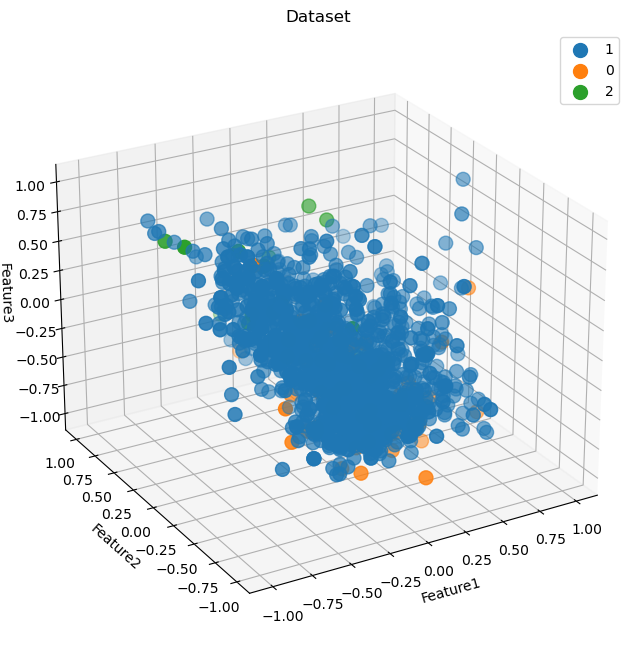

In [12]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in (y.unique()):
    row_ix = np.where(y== i)
    a=X[row_ix, 0]
    b=X[row_ix, 1]
    c=X[row_ix, 2]
    ax.scatter(a, b, c,s=100,label=i)

plt.title('Dataset')
ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
plt.legend()

ax.view_init( azim=-120, elev=25 );

5. Используя алгоритм снижения размерности данных, указанный в индивидуальном задании, уменьшите размерность признакового пространства до двух и визуализируйте набор данных в виде точек на плоскости, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

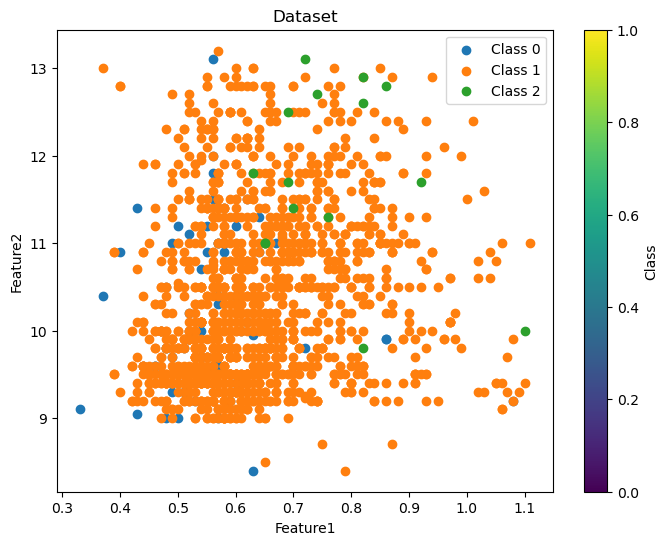

In [13]:
variances = df[[f1, f2, f3]].var()

feature_to_remove = variances.idxmin()
X_2 = df[[f1, f2, f3]].drop(columns=[feature_to_remove]).values

plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap('viridis', len(np.unique(y)))
for class_label in np.unique(y):
    plt.scatter(X_2[y == class_label, 0], X_2[y == class_label, 1], cmap=cmap, marker='o', label=f'Class {class_label}')
plt.title('Dataset')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.colorbar(label='Class')
plt.legend()
plt.show()

6. Используя разделение набора данных из двух признаков на обучающую и тестовую выборки в соотношении 75% на 25%, проведите классификацию тестовой выборки с помощью метода К ближайших соседей для различных значений К и определите оптимальное значение параметра К с минимальной долей ошибок. 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.25, random_state=666)

In [15]:
X_train.shape

(1143, 2)

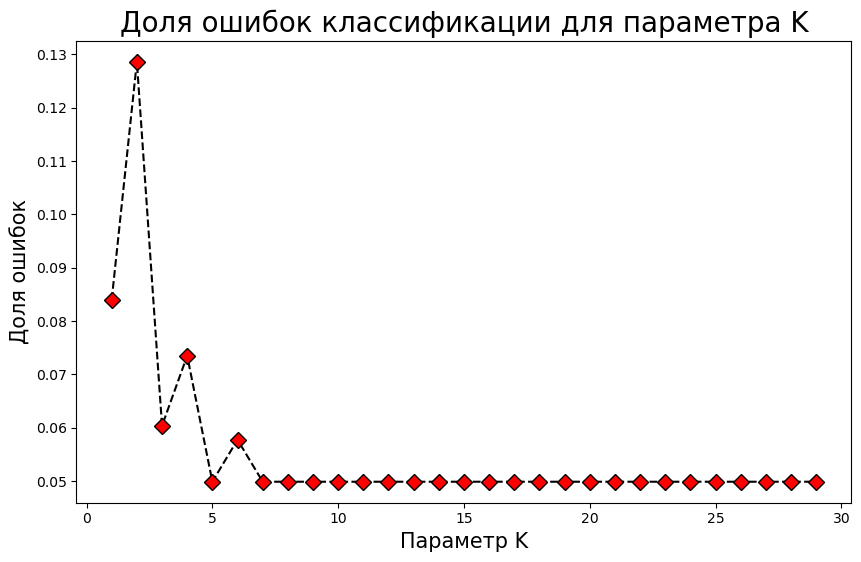

In [16]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
k = np.argmin(error_rate) + 1
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='black', linestyle='dashed', marker='D',
         markerfacecolor='red', markersize=8)
plt.title('Доля ошибок классификации для параметра K', fontsize=20)
plt.xlabel('Параметр K',fontsize=15)
plt.ylabel('Доля ошибок',fontsize=15);

7. Для найденного значения K постройте и выведите на экран отчет о классификации и матрицу ошибок.

In [17]:
k

5

In [18]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [19]:
conf_mat=confusion_matrix(y_test,y_pred)
conf_mat

array([[  0,  13,   0],
       [  0, 362,   0],
       [  0,   6,   0]], dtype=int64)

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.95      1.00      0.97       362
           2       0.00      0.00      0.00         6

    accuracy                           0.95       381
   macro avg       0.32      0.33      0.32       381
weighted avg       0.90      0.95      0.93       381



8. Создайте модели классификации точек набора данных из трех признаков на базе следующих классификаторов:
* наивного байесовского классификатора  
* классификатора метода К ближайших соседей для значения К, определенного в п. 6.

In [21]:
from sklearn.naive_bayes import GaussianNB
nbc = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=k) 

9. Используя указанный в индивидуальном задании метод валидации модели, проведите для набора данных из трех признаков оценку качества классификаторов из п. 8 относительно показателя, указанного в индивидуальном задании, и выведите на экран среднее значение и дисперсию этого показателя.

In [22]:
from sklearn.model_selection import ShuffleSplit
fold = ShuffleSplit(n_splits=5, test_size=0.25)

In [23]:
results_fold = cross_val_score(nbc, X, y, scoring="f1_macro",cv=fold)
print("Доля верных ответов_NBC (mean): %.2f%%" % (results_fold.mean()*100.0)) 
print("Доля верных ответов_NBC (var): %.2f%%" % (results_fold.var()*100.0)) 

Доля верных ответов_NBC (mean): 32.31%
Доля верных ответов_NBC (var): 0.00%


In [24]:
results_fold = cross_val_score(knn, X, y,scoring="f1_macro", cv=fold)
print("Доля верных ответов_KNN (mean): %.2f%%" % (results_fold.mean()*100.0)) 
print("Доля верных ответов_KNN (var): %.2f%%" % (results_fold.var()*100.0)) 

Доля верных ответов_KNN (mean): 39.18%
Доля верных ответов_KNN (var): 0.66%


10. Определите, какой из классификаторов позволяет получить более высокое среднее значение показателя классификации, проведите классификацию точек набора данных этим классификатором и визуализируйте набор данных в виде точек трехмерного пространства с координатами, соответствующими трем признакам, отображая точки различных прогнозируемых классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

In [27]:
clf = KNeighborsClassifier(n_neighbors=k) 
clf.fit(X,y)
y = pd.Series(clf.predict(X).astype(int))

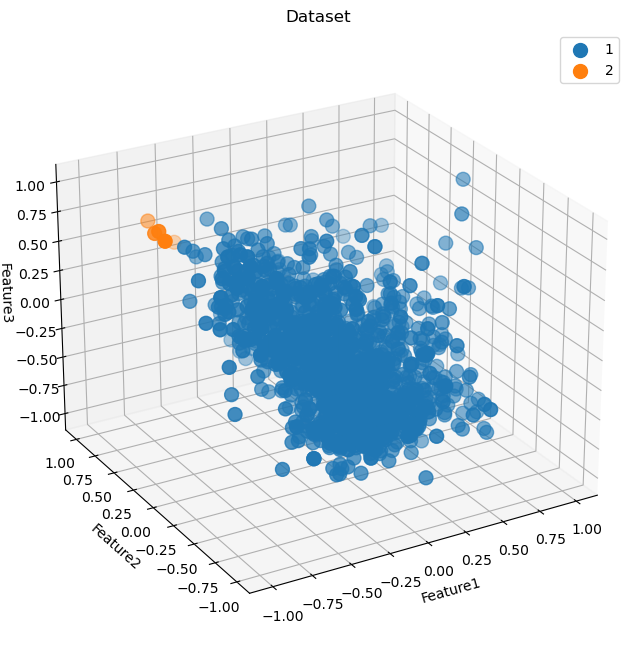

In [28]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in (y.unique()):
    row_ix = np.where(y== i)
    a=X[row_ix, 0]
    b=X[row_ix, 1]
    c=X[row_ix, 2]
    ax.scatter(a, b, c,s=100,label=i)

plt.title('Dataset')
ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
plt.legend()

ax.view_init( azim=-120, elev=25 );